In [1]:
import os
import time
import numpy as np
import pandas as pd

import numpy as np
from tqdm.notebook import tqdm

import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import normalize
from sklearn.metrics import confusion_matrix

import keras
import tensorflow as tf 
from keras.models import Sequential
from keras.layers import Dense
     
from keras import backend as K
from keras.layers import Conv2D, MaxPooling2D, Dropout, Flatten, BatchNormalization

from keras.callbacks import ModelCheckpoint
import warnings
warnings.filterwarnings('ignore')

gpu_devices = tf.config.experimental.list_physical_devices('GPU')
for device in gpu_devices:
    tf.config.experimental.set_memory_growth(device, True)
    
! for a in /sys/bus/pci/devices/*; do echo 0 | sudo tee -a $a/numa_node; done

a was unexpected at this time.


In [2]:
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

In [3]:
demographic = pd.read_csv(r"C:\Users\User\Downloads\archive (1)\demographic.csv")
demographic

,subject,group,gender,age,education
0,1,0,M,44,16.0
1,2,0,M,39,17.0
2,3,0,M,53,18.0
3,4,0,M,52,15.0
4,5,0,M,41,16.0
...,...,...,...,...,...
76,77,1,M,28,13.0
77,78,1,F,32,16.0
78,79,1,M,37,16.0
79,80,1,M,33,13.0


In [4]:
demographic[" group"].mean()

0.6049382716049383

In [5]:
demographic[" group"].value_counts()

1    49
0    32
Name:  group, dtype: int64

In [6]:
for i, t in enumerate(list(demographic[" group"])):

    
    if t:

        print(f"{i} - Schizophrenia")
    else:
        print(f"{i} - HEALTHY")

0 - HEALTHY
1 - HEALTHY
2 - HEALTHY
3 - HEALTHY
4 - HEALTHY
5 - HEALTHY
6 - HEALTHY
7 - HEALTHY
8 - HEALTHY
9 - HEALTHY
10 - HEALTHY
11 - HEALTHY
12 - HEALTHY
13 - HEALTHY
14 - HEALTHY
15 - HEALTHY
16 - HEALTHY
17 - HEALTHY
18 - HEALTHY
19 - HEALTHY
20 - HEALTHY
21 - HEALTHY
22 - HEALTHY
23 - HEALTHY
24 - Schizophrenia
25 - Schizophrenia
26 - Schizophrenia
27 - Schizophrenia
28 - Schizophrenia
29 - Schizophrenia
30 - Schizophrenia
31 - Schizophrenia
32 - Schizophrenia
33 - Schizophrenia
34 - Schizophrenia
35 - Schizophrenia
36 - Schizophrenia
37 - Schizophrenia
38 - Schizophrenia
39 - Schizophrenia
40 - Schizophrenia
41 - Schizophrenia
42 - Schizophrenia
43 - Schizophrenia
44 - Schizophrenia
45 - Schizophrenia
46 - Schizophrenia
47 - Schizophrenia
48 - Schizophrenia
49 - Schizophrenia
50 - Schizophrenia
51 - Schizophrenia
52 - Schizophrenia
53 - Schizophrenia
54 - Schizophrenia
55 - Schizophrenia
56 - Schizophrenia
57 - Schizophrenia
58 - HEALTHY
59 - HEALTHY
60 - HEALTHY
61 - HEALTHY


In [7]:
diagnosis_dict = dict(zip(demographic.subject, demographic[" group"]))
del demographic


In [8]:
electrodes_list = list(pd.read_csv(r"C:\Users\User\Downloads\archive (1)\columnLabels.csv").columns[4:])

print("Electrodes List \n",electrodes_list)

Electrodes List 
 ['Fp1', 'AF7', 'AF3', 'F1', 'F3', 'F5', 'F7', 'FT7', 'FC5', 'FC3', 'FC1', 'C1', 'C3', 'C5', 'T7', 'TP7', 'CP5', 'CP3', 'CP1', 'P1', 'P3', 'P5', 'P7', 'P9', 'PO7', 'PO3', 'O1', 'Iz', 'Oz', 'POz', 'Pz', 'CPz', 'Fpz', 'Fp2', 'AF8', 'AF4', 'AFz', 'Fz', 'F2', 'F4', 'F6', 'F8', 'FT8', 'FC6', 'FC4', 'FC2', 'FCz', 'Cz', 'C2', 'C4', 'C6', 'T8', 'TP8', 'CP6', 'CP4', 'CP2', 'P2', 'P4', 'P6', 'P8', 'P10', 'PO8', 'PO4', 'O2', 'VEOa', 'VEOb', 'HEOL', 'HEOR', 'Nose', 'TP10']


In [9]:
def averaged_by_N_rows(a, n):
    """ 
    A function that averages n rows in a matrix
    """
    shape = a.shape
    assert len(shape) == 2
    assert shape[0] % n == 0
    b = a.reshape(shape[0] // n, n, 
                  shape[1])
    mean_vec = b.mean(axis=1)
    return mean_vec

In [10]:
N_AVERAGED = 16
X = np.zeros((81 * 100,  9216 * len(electrodes_list) // N_AVERAGED), dtype="float32")
Y = np.zeros(len(X))

part1_path = r"C:\Users\User\Downloads\archive (1)"
part2_path = r"C:\Users\User\Downloads\archive (1)\2.csv"

# We pull out only those experiments where there were 9216 measurements (most often named so many times)
x_counter = 0
column_list = pd.read_csv(r"C:\Users\User\Downloads\archive (1)\columnLabels.csv").columns
for person_number in tqdm(range(1, 81 + 1)):


    csv_path = f"{part1_path}/{person_number}.csv/{person_number}.csv"
    if not os.path.exists(csv_path):
        csv_path = f"{part2_path}/{person_number}.csv/{person_number}.csv"
    df = pd.read_csv(csv_path, 
                header=None,
                names=column_list)
    trials_list = set(df.trial)


    for t1, trial_number in enumerate(trials_list):
        number_of_trials = len(df[df.trial == trial_number])
        if number_of_trials == 9216.0:
            current_sample_matrix = df[df.trial == trial_number][electrodes_list].values
            averaged_by_N = averaged_by_N_rows(current_sample_matrix, n=N_AVERAGED)
            averaged_by_N_big_vec = averaged_by_N.reshape(-1)
            X[x_counter] = averaged_by_N_big_vec.astype(np.float32)
            Y[x_counter] = diagnosis_dict[person_number]
            x_counter += 1
print("Total trials with the Appropriate number of measurements - ", x_counter)
X = X[: x_counter]
Y = Y[: x_counter]
        
print("Total trials with the Appropriate number of measurements- ", x_counter)



  0%|          | 0/81 [00:00<?, ?it/s]

Total trials with the Appropriate number of measurements -  7092
Total trials with the Appropriate number of measurements-  7092


Trial shape (flattened): (40320,)
Label (0=Healthy, 1=Schizophrenia): 0.0
Trial shape (reshaped): (576, 70)


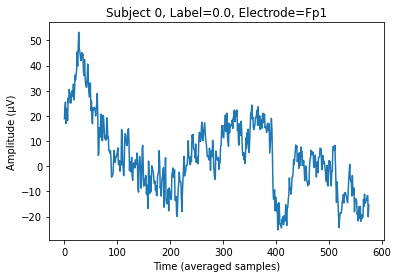

In [11]:
import matplotlib.pyplot as plt

# Pick one trial from your final dataset
idx = 0   # change this to look at other trials
trial_vector = X[idx]   # this is the flattened version
label = Y[idx]

print("Trial shape (flattened):", trial_vector.shape)
print("Label (0=Healthy, 1=Schizophrenia):", label)

# If you want to reshape it back to (time, channels):
n_channels = len(electrodes_list)
trial_matrix = trial_vector.reshape(-1, n_channels)
print("Trial shape (reshaped):", trial_matrix.shape)

# Plot one electrode (e.g., first channel)
plt.plot(trial_matrix[:, 0])
plt.title(f"Subject {idx}, Label={label}, Electrode={electrodes_list[0]}")
plt.xlabel("Time (averaged samples)")
plt.ylabel("Amplitude (µV)")
plt.show()


In [12]:
import pandas as pd
import os

# === Parameters ===
person_number = 1   # you can change this (1–81)
part1_path = r"C:\Users\User\Downloads\archive (1)"
part2_path = r"C:\Users\User\Downloads\archive (1)\2.csv"

# === Load subject data ===
column_list = pd.read_csv(r"C:\Users\User\Downloads\archive (1)\columnLabels.csv").columns
csv_path = f"{part1_path}/{person_number}.csv/{person_number}.csv"
if not os.path.exists(csv_path):
    csv_path = f"{part2_path}/{person_number}.csv/{person_number}.csv"

df = pd.read_csv(csv_path, header=None, names=column_list)

# === Find one trial with exactly 9216 samples ===
trial_df = None
for trial_number in df.trial.unique():
    tdf = df[df.trial == trial_number]
    if len(tdf) == 9216:
        trial_df = tdf
        print(f"Shape of one trial: {trial_df.shape}")
        print("Columns available:", trial_df.columns.tolist())
        print(trial_df.head(20))  # print first 20 rows
        break


Shape of one trial: (9216, 74)
Columns available: ['subject', 'trial', 'condition', 'sample', 'Fp1', 'AF7', 'AF3', 'F1', 'F3', 'F5', 'F7', 'FT7', 'FC5', 'FC3', 'FC1', 'C1', 'C3', 'C5', 'T7', 'TP7', 'CP5', 'CP3', 'CP1', 'P1', 'P3', 'P5', 'P7', 'P9', 'PO7', 'PO3', 'O1', 'Iz', 'Oz', 'POz', 'Pz', 'CPz', 'Fpz', 'Fp2', 'AF8', 'AF4', 'AFz', 'Fz', 'F2', 'F4', 'F6', 'F8', 'FT8', 'FC6', 'FC4', 'FC2', 'FCz', 'Cz', 'C2', 'C4', 'C6', 'T8', 'TP8', 'CP6', 'CP4', 'CP2', 'P2', 'P4', 'P6', 'P8', 'P10', 'PO8', 'PO4', 'O2', 'VEOa', 'VEOb', 'HEOL', 'HEOR', 'Nose', 'TP10']
      subject  trial  condition  sample      Fp1      AF7      AF3      F1  \
3072      1.0   10.0        1.0     1.0  21.5329  15.6374  21.9169  4.6073   
3073      1.0   10.0        1.0     2.0  19.1912  16.5885  22.7326  6.9358   
3074      1.0   10.0        1.0     3.0  17.5509  16.8669  23.8866  8.5715   
3075      1.0   10.0        1.0     4.0  17.5762  19.1323  26.1499  9.2978   
3076      1.0   10.0        1.0     5.0  17.8254  18

In [13]:
X.shape

(7092, 40320)

In [14]:
Y.shape



(7092,)

In [15]:
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, shuffle=True, random_state=42)


In [16]:
X_norm = (normalize(X.reshape(-1, 70), axis=0, norm='max')).reshape(X.shape)


In [17]:
X_train_norm, X_test_norm, Y_train_norm, Y_test_norm = train_test_split(X_norm, Y, test_size=0.2, shuffle=True, random_state=42)


In [18]:
_norm = X



In [19]:
X_train_2d = X_train_norm.reshape(X_train_norm.shape[0], len(electrodes_list), X_train_norm.shape[1] // len(electrodes_list), 1)
X_test_2d = X_test_norm.reshape(X_test_norm.shape[0], len(electrodes_list), X_test_norm.shape[1] // len(electrodes_list), 1)

In [24]:
import os
import json
import numpy as np
import pandas as pd
import mne
from mne.time_frequency import tfr_array_morlet
import matplotlib
matplotlib.use('Agg')
import matplotlib.pyplot as plt
import gc
from scipy.signal import detrend

# =========================================================
# === User Settings =======================================
# =========================================================
data_dir = r"C:\Users\User\Downloads\archive (1)"
demographic_path = os.path.join(data_dir, "demographic.csv")
column_labels_path = os.path.join(data_dir, "columnLabels.csv")

etr_save_path_norm = r"D:\Research Works\ETR\norm1024_64correcthah"
etr_save_path_sch  = r"D:\Research Works\ETR\sch1024_64correcthah"
os.makedirs(etr_save_path_norm, exist_ok=True)
os.makedirs(etr_save_path_sch, exist_ok=True)

# Choose algorithm (R1..R6)
SELECTED_ALGO = 'R2'

# =========================================================
# === EEG Info ============================================
# =========================================================
ch_subset = [
 'Fp1','AF7','AF3','F1','F3','F5','F7','FT7','FC5','FC3','FC1','C1','C3','C5','T7',
 'TP7','CP5','CP3','CP1','P1','P3','P5','P7','P9','PO7','PO3','O1','Iz','Oz','POz',
 'Pz','CPz','Fpz','Fp2','AF8','AF4','AFz','Fz','F2','F4','F6','F8','FT8','FC6','FC4',
 'FC2','FCz','Cz','C2','C4','C6','T8','TP8','CP6','CP4','CP2','P2','P4','P6','P8',
 'P10','PO8','PO4','O2','TP10']
sfreq = 1024.0
montage = mne.channels.make_standard_montage("standard_1020")

# =========================================================
# === Constants ==========================================
# =========================================================
PAPER_M1 = 2e-10
PAPER_M2 = 1.3e-10
PAPER_M3 = 0.525

POWER_BARS = {
    '9-30': {
        'R1': (-4.0e-10, 5.5e-10),
        'R2': (-1.0, 4.5),
        'R3': (-1.5, 0.4),
        'R4': (-1.8, 3.0),
        'R5': (-3.0, 4.0),
        'R6': (-2.5, 1.0),
    }
}

MIN_FREQ = 9.0
MAX_FREQ = 35.0
FREQS_FULL = np.arange(MIN_FREQ, MAX_FREQ+1, 1.0)
DEFAULT_N_CYCLES = 7.0
EPS = 1e-20

# Cache path for calibration
M123_CACHE = os.path.join(os.getcwd(), "m123_global_9_30.json")

# =========================================================
# === Helper Functions ===================================
# =========================================================
def adjust_n_cycles(n_cycles, sfreq, freqs, epoch_len_samples):
    max_wavelet = n_cycles / min(freqs) * sfreq
    if max_wavelet > epoch_len_samples:
        return n_cycles * epoch_len_samples / max_wavelet * 0.9
    return n_cycles

def load_subject(subject_id, column_list, data_dir=data_dir):
    path1 = os.path.join(data_dir, f"{subject_id}.csv", f"{subject_id}.csv")
    path2 = os.path.join(data_dir, "2.csv", f"{subject_id}.csv", f"{subject_id}.csv")
    if os.path.exists(path1):
        return pd.read_csv(path1, header=None, names=column_list, dtype=np.float32)
    elif os.path.exists(path2):
        return pd.read_csv(path2, header=None, names=column_list, dtype=np.float32)
    else:
        print(f"⚠ Subject {subject_id} missing!")
        return None

def car_reference(epoch_array):
    return (epoch_array - epoch_array.mean(axis=0, keepdims=True)).astype(np.float32)

def baseline_remove(epoch_array):
    return (epoch_array - epoch_array.mean(axis=1, keepdims=True)).astype(np.float32)

def preprocess_epoch_array(epoch_array):
    x = detrend(epoch_array, axis=1, type='linear')
    x = baseline_remove(x)
    x = car_reference(x)
    return x.astype(np.float32)

def tfr_epochs_morlet(epochs_array, freqs=FREQS_FULL, n_cycles=DEFAULT_N_CYCLES, sfreq=sfreq):
    n_times = epochs_array.shape[2]
    n_cycles = adjust_n_cycles(n_cycles, sfreq, freqs, n_times)
    return tfr_array_morlet(epochs_array.astype(np.float32), sfreq=sfreq,
                            freqs=freqs, n_cycles=n_cycles, output='complex', n_jobs=1)

def compute_Rs_from_power_slice(power_slice, m1, m2, m3):
    n_ch, nf, nt = power_slice.shape
    X = power_slice.reshape(n_ch, nf*nt)
    R = {}
    R['R1'] = np.mean(X - m1, axis=1)
    R['R2'] = np.mean(X / (m2 + EPS), axis=1)
    R['R3'] = np.mean(np.log10((X / (m1 + EPS)) + EPS), axis=1)
    R['R4'] = np.mean((X - m1) / (m1 + EPS), axis=1)
    R['R5'] = np.mean((X - m1) / (m2 + EPS), axis=1)
    R['R6'] = np.mean(np.log10((X / (m1 + EPS)) + EPS) / (m3 + EPS), axis=1)
    return R

def normalize_R_vector(R_vector, algo='R2'):
    """Clip and normalize to fixed global min/max per algorithm."""
    vmin, vmax = POWER_BARS['9-30'][algo]
    R_vector = np.clip(R_vector, vmin, vmax)
    return R_vector

def plot_and_save_topomap(cfv_vector, info, file_name, vmin=None, vmax=None, size_px=200):
    fig, ax = plt.subplots(figsize=(size_px/100, size_px/100), dpi=100)
    mne.viz.plot_topomap(cfv_vector, info, axes=ax, show=False,
                         vmin=vmin, vmax=vmax, sensors=False, contours=0)
    plt.axis('off')
    fig.savefig(file_name, dpi=100, bbox_inches='tight', pad_inches=0)
    plt.close(fig)

# =========================================================
# === Global Calibration =================================
# =========================================================
def calibrate_m123_global(force=False):
    if (not force) and os.path.exists(M123_CACHE):
        with open(M123_CACHE, 'r') as f:
            vals = json.load(f)
        return float(vals['m1']), float(vals['m2']), float(vals['m3'])

    demographic = pd.read_csv(demographic_path)
    if os.path.exists(column_labels_path):
        column_list = pd.read_csv(column_labels_path).columns.tolist()
    else:
        column_list = None

    samples = []
    for subj in demographic.subject:
        df = load_subject(subj, column_list, data_dir)
        if df is None: continue
        valid_channels = [ch for ch in ch_subset if ch in df.columns]
        if not valid_channels: continue
        data = df[valid_channels].values.T.astype(np.float32)
        if data.shape[1] < int(sfreq*1.5): continue
        epoch = preprocess_epoch_array(data[:, :int(sfreq*1.5)])
        tfr_c = tfr_epochs_morlet(epoch[None, :, :], freqs=FREQS_FULL, sfreq=sfreq)
        power = np.abs(tfr_c)**2
        fmask = (FREQS_FULL >= 9) & (FREQS_FULL <= 30)
        samples.append(power[0, :, fmask, :].ravel())
        df = None

    big = np.concatenate(samples) if samples else np.array([PAPER_M1])
    m1 = float(np.median(big))
    mad = np.median(np.abs(big - m1)) + 1e-30
    m2 = float(1.4826 * mad)
    log_rat = np.log10((big / (m1 + 1e-30)) + 1e-30)
    m3 = float(np.std(log_rat))
    with open(M123_CACHE, 'w') as f:
        json.dump({'m1': m1, 'm2': m2, 'm3': m3}, f)
    print(f"[GLOBAL CALIBRATION] m1={m1:.3e}, m2={m2:.3e}, m3={m3:.3f}")
    return m1, m2, m3

# =========================================================
# === Main Processing ====================================
# =========================================================
def compute_ETR_for_trial(epochs, freqs=FREQS_FULL, freq_band=(9.0,30.0),
                          m1=PAPER_M1, m2=PAPER_M2, m3=PAPER_M3):
    tfr_complex = tfr_epochs_morlet(epochs, freqs=freqs, sfreq=sfreq)
    power = np.abs(tfr_complex)**2
    freq_mask = (freqs >= freq_band[0]) & (freqs <= freq_band[1])
    power_slice = power[:, :, freq_mask, :].mean(axis=0)  # average across epochs
    R = compute_Rs_from_power_slice(power_slice, m1, m2, m3)
    return R[SELECTED_ALGO]

def generate_etrs_for_all_subjects():
    global PAPER_M1, PAPER_M2, PAPER_M3
    PAPER_M1, PAPER_M2, PAPER_M3 = calibrate_m123_global(force=False)

    demographic = pd.read_csv(demographic_path)
    if os.path.exists(column_labels_path):
        column_list = pd.read_csv(column_labels_path).columns.tolist()
    else:
        column_list = None
    diagnosis_dict = dict(zip(demographic.subject, demographic[" group"]))

    vmin, vmax = POWER_BARS['9-30'][SELECTED_ALGO]  # fixed global scale

    for subj in demographic.subject:
        df = load_subject(subj, column_list, data_dir)
        if df is None: continue
        label = diagnosis_dict[subj]
        subj_out_base = etr_save_path_norm if label==0 else etr_save_path_sch
        os.makedirs(subj_out_base, exist_ok=True)
        print(f"\nProcessing Subject {subj} ({'Healthy' if label==0 else 'Sch'})")

        for trial_number, g in df.groupby("trial"):
            valid_channels = [ch for ch in ch_subset if ch in g.columns]
            if not valid_channels: continue
            data = g[valid_channels].values.T.astype(np.float32)
            n_samples = data.shape[1]
            n_epoch_len = int(sfreq*1.5)
            if n_samples < n_epoch_len: continue
            n_epochs = n_samples // n_epoch_len
            data = data[:, :n_epochs*n_epoch_len]
            epochs = data.reshape(len(valid_channels), n_epochs, n_epoch_len).transpose(1,0,2)
            epochs_pp = np.array([preprocess_epoch_array(e) for e in epochs], dtype=np.float32)

            averaged_R = compute_ETR_for_trial(epochs_pp, freqs=FREQS_FULL,
                                               freq_band=(9.0,30.0),
                                               m1=PAPER_M1, m2=PAPER_M2, m3=PAPER_M3)

            # normalize for consistent color scale
            averaged_R_norm = normalize_R_vector(averaged_R, algo=SELECTED_ALGO)

            info_plot = mne.create_info(ch_names=valid_channels[:len(averaged_R_norm)],
                                        sfreq=sfreq, ch_types=['eeg']*len(averaged_R_norm))
            info_plot.set_montage(montage)

            fname = os.path.join(subj_out_base,
                                 f"{subj}_trial{trial_number}_{SELECTED_ALGO}.png")
            plot_and_save_topomap(averaged_R_norm, info_plot, fname,
                                  vmin=vmin, vmax=vmax, size_px=200)
            print(f"   Saved {fname}")

        del df
        gc.collect()
        print(f"✅ Finished subject {subj}")

# =========================================================
# === Run pipeline ========================================
# =========================================================
if __name__ == "__main__":
    generate_etrs_for_all_subjects()




Processing Subject 1 (Healthy)
   Saved D:\Research Works\ETR\norm1024_64correcthah\1_trial1.0_R2.png
   Saved D:\Research Works\ETR\norm1024_64correcthah\1_trial2.0_R2.png
   Saved D:\Research Works\ETR\norm1024_64correcthah\1_trial3.0_R2.png
   Saved D:\Research Works\ETR\norm1024_64correcthah\1_trial4.0_R2.png
   Saved D:\Research Works\ETR\norm1024_64correcthah\1_trial5.0_R2.png
   Saved D:\Research Works\ETR\norm1024_64correcthah\1_trial6.0_R2.png
   Saved D:\Research Works\ETR\norm1024_64correcthah\1_trial7.0_R2.png
   Saved D:\Research Works\ETR\norm1024_64correcthah\1_trial8.0_R2.png
   Saved D:\Research Works\ETR\norm1024_64correcthah\1_trial9.0_R2.png
   Saved D:\Research Works\ETR\norm1024_64correcthah\1_trial10.0_R2.png
   Saved D:\Research Works\ETR\norm1024_64correcthah\1_trial11.0_R2.png
   Saved D:\Research Works\ETR\norm1024_64correcthah\1_trial12.0_R2.png
   Saved D:\Research Works\ETR\norm1024_64correcthah\1_trial13.0_R2.png
   Saved D:\Research Works\ETR\norm1024_6

FileNotFoundError: [WinError 3] The system cannot find the path specified: 'D:\\Research Works\\ETR_train'